In [7]:
import numpy as np


def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))


def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)


class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass


class Dense(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = np.array(input, dtype=np.float64)
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        output_gradient = np.array(output_gradient, dtype=np.float64)
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient


class Activation(Layer):
    def __init__(self, activation, activation_prime):
        super().__init__()
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))


class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)


def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output


def test(network, input_data, output_data, loss) -> (float, np.array):
    error = 0
    predictions = []
    for x, y in zip(input_data, output_data):
        # forward
        output = predict(network, x)
        predictions.append(output)  # Collect predictions
        # error
        error += loss(y, output)

    error /= len(input_data)
    predictions = np.array(predictions)
    return error, predictions


def train(network, loss, loss_prime, x_train, y_train, epochs=1000, learning_rate=0.01, verbose=True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)
            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

In [ ]:
import numpy as np
from scipy import signal


class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)


class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        super().__init__()
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient


class MaxPooling(Layer):
    def __init__(self, pool_size):
        super().__init__()
        self.pool_size = pool_size

    def forward(self, input):
        self.input = input
        depth, height, width = input.shape
        pooled_height = height // self.pool_size
        pooled_width = width // self.pool_size
        self.output = np.zeros((depth, pooled_height, pooled_width))

        for d in range(depth):
            for ph in range(pooled_height):
                for pw in range(pooled_width):
                    h_start = ph * self.pool_size
                    h_end = h_start + self.pool_size
                    w_start = pw * self.pool_size
                    w_end = w_start + self.pool_size
                    window = input[d, h_start:h_end, w_start:w_end]
                    self.output[d, ph, pw] = np.max(window)

        return self.output

    def backward(self, output_gradient, learning_rate):
        depth, pooled_height, pooled_width = output_gradient.shape
        input_gradient = np.zeros_like(self.input)

        for d in range(depth):
            for ph in range(pooled_height):
                for pw in range(pooled_width):
                    h_start = ph * self.pool_size
                    h_end = h_start + self.pool_size
                    w_start = pw * self.pool_size
                    w_end = w_start + self.pool_size
                    window = self.input[d, h_start:h_end, w_start:w_end]
                    max_value = np.max(window)
                    mask = (window == max_value)
                    input_gradient[d, h_start:h_end, w_start:w_end] += mask * output_gradient[d, ph, pw]

        return input_gradient

In [11]:
from keras.datasets import mnist
from keras.utils import to_categorical

def preprocess_data1(x, y, limit):
    x = x.reshape(x.shape[0], 1,  28, 28)
    x = x.astype("float32") / 255
    y = to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]


# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data1(x_train, y_train, y_train.shape[0])
x_test, y_test = preprocess_data1(x_test, y_test, y_test.shape[0])
print(y_train.shape[0], y_test.shape[0])

60000 10000


In [12]:
kernel1 = 5
kernels1 = 5
kernel2 = 5
kernels2 = 3

b = (28-kernel1+1)//2
c = b-kernel2+1
network = [
    Convolutional((1, 28, 28), kernel1, kernels1),
    Sigmoid(),
    MaxPooling(2),
    Convolutional((kernels1, b, b), kernel2, kernels2),
    Sigmoid(),
    Reshape((kernels2, c, c), (kernels2 * c * c, 1)),
    Dense(kernels2 * c * c, 32),
    Sigmoid(),
    Dense(32, 10),
    Sigmoid()
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=5,
    learning_rate=0.1
)

error, predictions = test(network, x_test, y_test, binary_cross_entropy)

print(f"error = {error}")

1/5, error=0.14048830496190884
2/5, error=0.07353281970492064
3/5, error=0.060881942396327965
4/5, error=0.05263072813228347
5/5, error=0.04714167873525613
error = 0.04510962232105589


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def predictions_to_labels(predictions):
    return predictions.argmax(axis=1)

# Convert predictions and true labels to label indices
y_pred = predictions_to_labels(predictions.squeeze())
y_true = y_test.argmax(axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average=None, zero_division=1)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Print the statistics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9322
Precision: [0.95219124 0.95392491 0.9498998  0.87191217 0.95685005 0.94896719
 0.95487179 0.95353749 0.94273595 0.85509839]
Recall: [0.9755102  0.98502203 0.91860465 0.94356436 0.90325866 0.87556054
 0.97181628 0.87840467 0.91273101 0.94747275]
F1 Score: [0.96370968 0.9692241  0.93399015 0.9063243  0.92928235 0.91078717
 0.96326953 0.91443038 0.92749087 0.89891866]


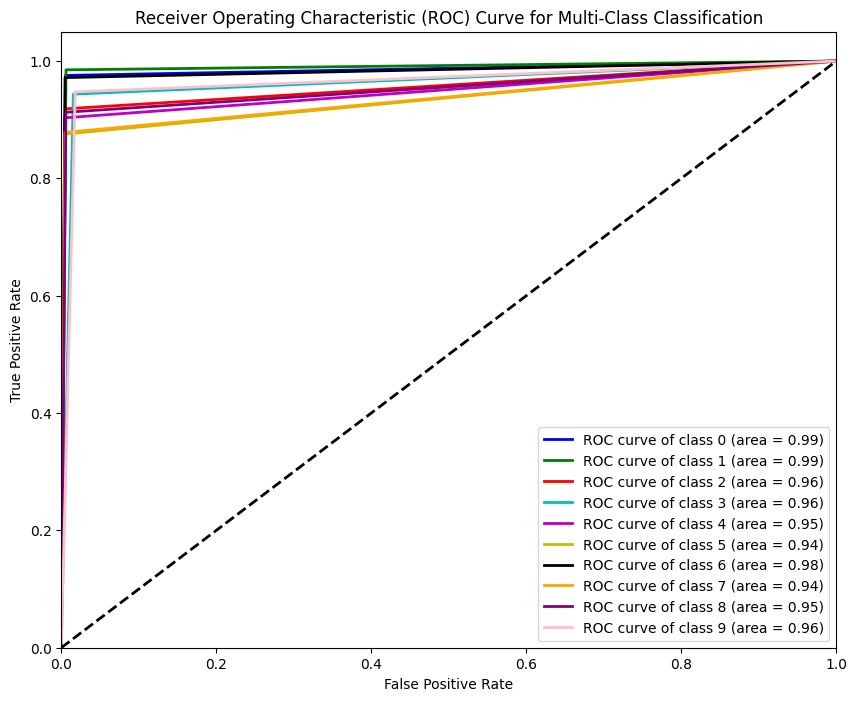

In [44]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_pred_probs = y_pred
y_true_binary = label_binarize(y_true, classes=np.unique(y_true))
y_pred_binary = label_binarize(y_pred, classes=np.unique(y_pred))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_true_binary.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink']  # Выбор цветов для каждого класса
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()
